In [1]:
import logging
import time
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch import cuda

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
import import_ipynb

from CGAN import CGAN ##### select CGAN model
from utils import get_data_loader, generate_images, save_gif
import LeNet

In [5]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [6]:
#hyperparameter settings
args = type('test', (object,), {})()
args.num_epochs = 1 #####10
args.ngpu = 1
args.ndf = 128
args.ngf = 128
args.nz = 100
args.lr = 0.0002
args.beta = 0.5
args.nc = 1
args.batch_size = 60 #####64
args.image_size = 32
args.num_test_samples = 64
args.output_path = "./results/"
args.fps = 5
args.use_fixed = True
args.plot = True

In [7]:
# Gather MNIST Dataset
transform=transforms.Compose([
                           transforms.Resize(args.image_size),
                           transforms.CenterCrop(args.image_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=0.5, std=0.5)
                        #    transforms.Normalize(mean=(0.1307, ), std=(0.3081, )),
                       ])    
dataset = dset.MNIST(root='./mnist_data/',
                       transform=transform, download=True)

In [8]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                                     shuffle=True)


In [9]:
# Device configuration
device = torch.device('cuda:0' if (torch.cuda.is_available() and args.ngpu > 0) else 'cpu')
print("Using", cuda.get_device_name(0))

Using NVIDIA GeForce RTX 3090


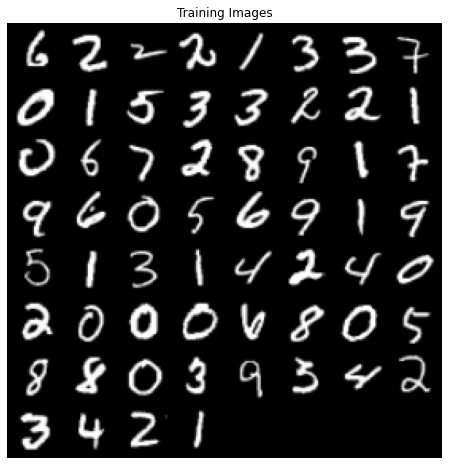

In [10]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
cgan = CGAN(ngpu=args.ngpu, device=device, lr=args.lr, nc=args.nc, ndf=args.ndf, nz=args.nz, ngf=args.ngf, beta1=args.beta)

In [12]:
# initialize other variables
num_batches = len(dataloader)
fixed_noise = torch.randn(args.num_test_samples, args.nz, 1, 1, device=device)

Starting Training Loop...
[0/1][0/1000]	Loss_D: 1.8556	Loss_G: 0.0308	D(x): 0.2742	D(G(z)): 0.2274 / 0.9719
[0/1][50/1000]	Loss_D: 1.5791	Loss_G: 6.2444	D(x): 0.6210	D(G(z)): 0.0117 / 0.0619
[0/1][100/1000]	Loss_D: 0.8144	Loss_G: 7.3221	D(x): 0.8440	D(G(z)): 0.2489 / 0.0022
[0/1][150/1000]	Loss_D: 1.7718	Loss_G: 11.6025	D(x): 0.8644	D(G(z)): 0.6455 / 0.0001
[0/1][200/1000]	Loss_D: 0.8057	Loss_G: 5.7941	D(x): 0.8548	D(G(z)): 0.3654 / 0.0179
[0/1][250/1000]	Loss_D: 0.8171	Loss_G: 8.8013	D(x): 0.9289	D(G(z)): 0.4138 / 0.0004
[0/1][300/1000]	Loss_D: 0.6325	Loss_G: 4.9531	D(x): 0.8956	D(G(z)): 0.3179 / 0.0168
[0/1][350/1000]	Loss_D: 0.5642	Loss_G: 2.1440	D(x): 0.7058	D(G(z)): 0.0405 / 0.1828
[0/1][400/1000]	Loss_D: 0.9502	Loss_G: 3.4874	D(x): 0.7551	D(G(z)): 0.1557 / 0.1483
[0/1][450/1000]	Loss_D: 0.9514	Loss_G: 5.4203	D(x): 0.7786	D(G(z)): 0.2955 / 0.0172
[0/1][500/1000]	Loss_D: 0.5504	Loss_G: 7.5629	D(x): 0.9678	D(G(z)): 0.3306 / 0.0015
[0/1][550/1000]	Loss_D: 1.2929	Loss_G: 2.5084	D(x): 

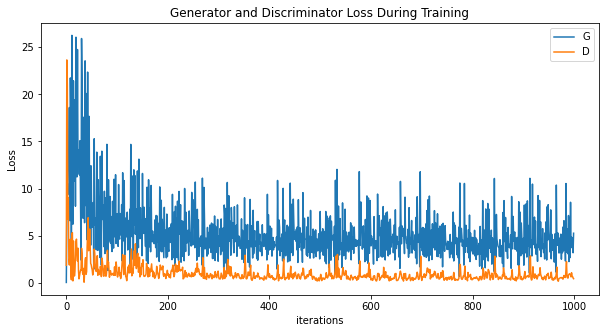

In [13]:
img_list = cgan.train(dataloader=dataloader, num_epochs=args.num_epochs, plot=args.plot)

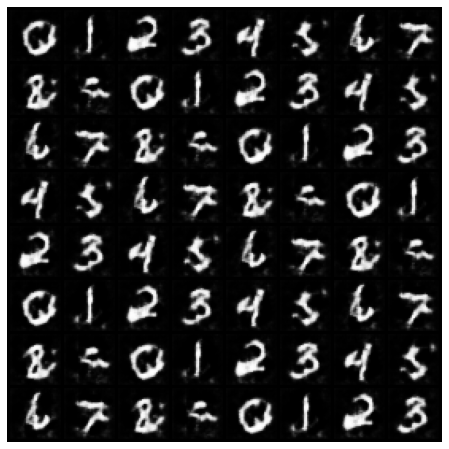

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
writergif = animation.PillowWriter(fps=30) 
ani.save(args.output_path+"fake_cgan.gif", writer=writergif)

In [15]:
#save model
model_path = "./models/"
filename = "cgan_Q2.pt"
torch.save(cgan, model_path+filename)

In [16]:
#load model
model_path = "./models/"
filename = "cgan_Q2.pt"
cgan = torch.load(model_path+filename)

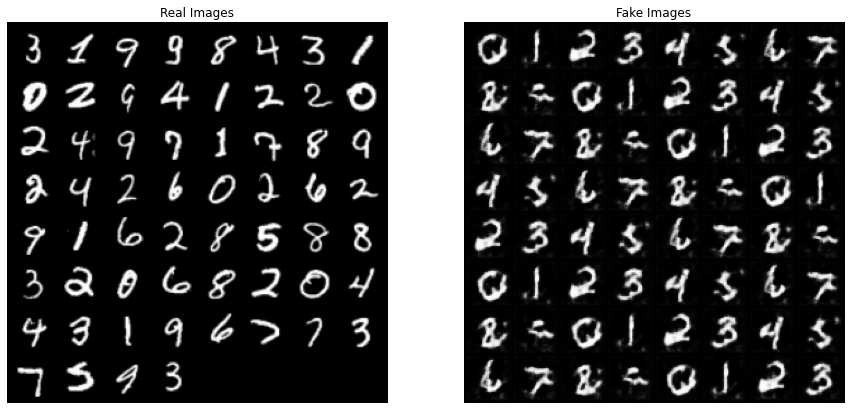

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [18]:
classifier = LeNet.Classifier(device)

In [19]:
#train classifier
model_path = "./models/"
filename = "lenet_Q2.pt"
classifier.train(num_epochs=1, model_path=model_path, filename=filename)

EPOCH 0 ...
Validation Accuracy = 0.969

Test Accuracy = 0.967
Model saved


In [20]:
#load lenet classifier
model_path = "./models/"
filename = "lenet_Q2.pt"
classifier.load(model_path, filename)

Model loaded


In [21]:
#create fake dataset and dataloader
fake_dataset, fake_dataloader = cgan.create_dataloader(num_samples=1000, batch_size=128)
#####for i, (image, label) in enumerate(fake_dataset):
#####    print(i)
#####    print(image)
#####    print(label)
for i, (image, label) in enumerate(fake_dataloader):
    print(i)
    print(image)
    print(label)

0
tensor([[[[-0.9530, -0.9682, -0.9698,  ..., -0.9837, -0.9848, -0.9802],
          [-0.9644, -0.9782, -0.9800,  ..., -0.9940, -0.9888, -0.9862],
          [-0.9567, -0.9833, -0.9849,  ..., -0.9947, -0.9888, -0.9824],
          ...,
          [-0.9726, -0.9859, -0.9887,  ..., -0.9800, -0.9792, -0.9764],
          [-0.9661, -0.9737, -0.9748,  ..., -0.9625, -0.9825, -0.9830],
          [-0.9551, -0.9731, -0.9694,  ..., -0.9596, -0.9725, -0.9738]]],


        [[[-0.9574, -0.9629, -0.9647,  ..., -0.9678, -0.9759, -0.9803],
          [-0.9566, -0.9714, -0.9784,  ..., -0.9774, -0.9651, -0.9757],
          [-0.9420, -0.9729, -0.9741,  ..., -0.9774, -0.9734, -0.9737],
          ...,
          [-0.9538, -0.9765, -0.9866,  ..., -0.9736, -0.9798, -0.9795],
          [-0.9539, -0.9699, -0.9870,  ..., -0.9541, -0.9798, -0.9835],
          [-0.9511, -0.9745, -0.9827,  ..., -0.9446, -0.9621, -0.9752]]]])
tensor([0, 1], device='cuda:0')


In [22]:
#evaluate on fake data
classifier.evaluate(new_dataloader, fake_dataset)

NameError: name 'new_dataloader' is not defined